In [ ]:
!rm -r /content/sample_data # i hate  this folder a lot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!unrar x '/content/drive/MyDrive/Colab Notebooks/The BioMassters/src.rar' '/content'

In [ ]:
%%capture
!unrar x '/content/drive/MyDrive/Colab Notebooks/The BioMassters/test.rar' '/content'

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
!pip install segmentation-models-pytorch
!pip install pytorch-lightning
!pip install -U albumentations

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

from src.d_m import DataModule
from src.models.unet import UNet

print('albumentations :', A.__version__)
print('cv2 :',cv2.__version__)
print("torch :", torch.__version__)

albumentations : 1.3.0
cv2 : 4.6.0
torch : 1.13.0+cu116


In [ ]:
#['September', 'July', 'August']
dm = DataModule(month = ['September'] , batch_size=4, val_size=0.1)
dm.setup()

train: 7820
val: 869
test: 2773


In [ ]:
# for test
ima, labels = next(iter(dm.test_dataloader()))
ima[0].shape, ima[1].shape, ima[2].shape

(torch.Size([4, 1, 3, 256, 256]),
 torch.Size([4, 1, 3, 256, 256]),
 torch.Size([4, 1, 3, 256, 256]))

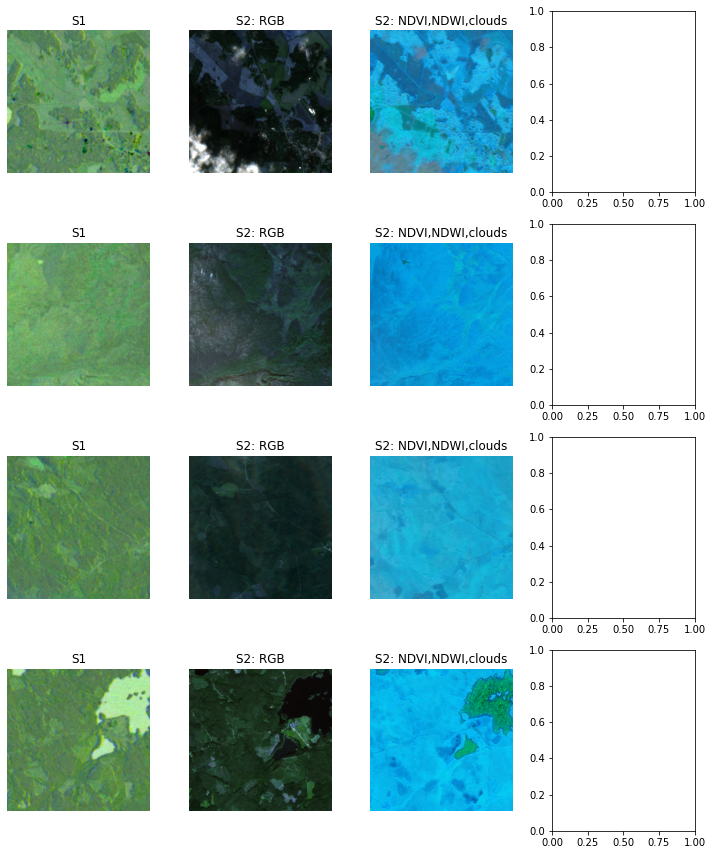

In [ ]:
all, labels = next(iter(dm.test_dataloader(shuffle=False)))
s1, s2, s3 = all
fig = plt.figure(figsize=(10, 12))
month = 0
#fig.suptitle(dm.month[0])
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    #ax.set_title(str(s1[i][0].shape))
    ax.set_title("S1")
    ax.imshow(s1[i][month].permute(1, 2, 0))
    #ax.imshow(s1[i][2])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    #ax.set_title(str(s2[i][0].shape))
    ax.set_title("S2: RGB")
    ax.imshow(s2[i][month].permute(1, 2, 0))
    #ax.imshow(s2[i][2])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    #ax.set_title(str(s3[i][0].shape))
    ax.set_title("S2: NDVI,NDWI,clouds")
    ax.imshow(s3[i][month].permute(1, 2, 0))
    #ax.imshow(s3[i][2])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    #ax.set_title(str(labels[i].shape))
    #ax.set_title("Agbm")
    #ax.imshow(labels[i])
    #ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import glob
my_ckpt = '/content/drive/MyDrive/Colab Notebooks/The BioMassters/checkpoints'
models = glob.glob(f'{my_ckpt}/*.ckpt')
models

['/content/drive/MyDrive/Colab Notebooks/The BioMassters/checkpoints/August-3-sat-25e-val_metric=36.41953-epoch=102.ckpt',
 '/content/drive/MyDrive/Colab Notebooks/The BioMassters/checkpoints/July-3-sat-110e-val_metric=35.49632-epoch=87.ckpt',
 '/content/drive/MyDrive/Colab Notebooks/The BioMassters/checkpoints/Set-3-sat-110e-val_metric=38.69678-epoch=109.ckpt']

In [ ]:
hparams = {
    'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels1': 3,
    'in_channels2': 3,
    'in_channels3': 3,
}

#state_dict = torch.load(models[2], map_location=torch.device('cpu'))['state_dict'] # gpu
state_dict = torch.load(models[2])['state_dict'] # GPU
module = UNet(hparams)
module.load_state_dict(state_dict)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
all, labels = next(iter(dm.test_dataloader(shuffle=False)))
p = module.predict(all)
#m =  module.compute_metrics(p, labels) # computing metric
#print(f"Prediction: {m:.4f}")
p.shape

torch.Size([4, 256, 256])

In [ ]:
# ['September', 'July', 'August']
dm16 = DataModule(month = ['September'] , batch_size=16, val_size=0.1)
dm16.setup() # start data module
all, labels = next(iter(dm16.val_dataloader(shuffle=False))) # create val dataloader
print("doing predictions...")
p = module.predict(all)# prediction
print("calclulate metric...")
m =  module.compute_metrics(p, labels) # computing metric
print(f"Prediction: {m:.4f}")

train: 7820
val: 869
test: 2773
doing predictions...
calclulate metric...
Prediction: 36.7711


In [ ]:
def test():
    print("loading model...")
    state_dict = torch.load(models[2], map_location=torch.device('cpu'))['state_dict']
    module = UNet(hparams)
    module.load_state_dict(state_dict)
    print("loading dataMododule...")
    # ['September', 'July', 'August']
    dm16 = DataModule(month = ['September'] , batch_size=16, val_size=0.1)
    dm16.setup() # start data module
    all, labels = next(iter(dm16.val_dataloader(shuffle=False))) # create val dataloader
    print("doing predictions...")
    p = module.predict(all)# prediction
    #print("calclulate metric...")
    m =  module.compute_metrics(p, labels) # computing metric
    print(f"Prediction: {m:.4f}")

In [ ]:
test()

loading model...
loading dataMododule...
train: 7820
val: 869
test: 2773
doing predictions...
Prediction: 36.7711


In [ ]:
from tqdm import tqdm
def val(modelo=2, mes=['September']):
    #print("loading model...")
    #state_dict = torch.load(models[modelo], map_location=torch.device('cpu'))['state_dict'] # cpu
    state_dict = torch.load(models[modelo])['state_dict'] # GPU
    module = UNet(hparams)
    module.load_state_dict(state_dict)
    #print("loading dataMododule...")
    # ['September', 'July', 'August']
    dm16 = DataModule(month = mes , batch_size=16, val_size=0.01)
    dm16.setup() # start data module
    #all, labels = next(iter(dm16.val_dataloader(shuffle=False))) # create val dataloader
    metric = []
    preds = torch.tensor([])
    gts = torch.tensor([])
    gts = []
    for batch in tqdm(dm16.test_dataloader(shuffle=False)):
        x, y = batch
        #print("doing predictions...")
        p = module.predict(x)# prediction
        #print("calclulate metric...")
        preds = torch.cat([preds, p])
        #gts = torch.cat([gts, y])
        gts.append(y)
        #metric.append(module.compute_metrics(p, y).item())
        #print(f"Prediction: {m:.4f}")
    #print(f"Mean prediction: {np.mean(metric):.4f}")
    return preds, gts
    

In [ ]:
 s , g  = val() 

In [ ]:
s.shape, len(g), len(s)

(torch.Size([2773, 256, 256]), 174, 2773)

In [ ]:
# this function change the dimension in a list, two dimensions in one dimension in list
def twoone(list1):
    return [val for lst in list1 for val in lst]

In [ ]:
g2 = twoone(g)
len(g2),g2[32] 

(2773, '04307f02')

In [ ]:
preds = []
p , g = val(1,['July'])
preds.append(p)
p , g = val(0,['August'])
preds.append(p)
p , g = val()
preds.append(p)
preds = torch.stack(preds)

preds.shape, len(g)

train: 8602
val: 87
test: 2773


100%|██████████| 174/174 [15:59<00:00,  5.52s/it]


train: 8602
val: 87
test: 2773


100%|██████████| 174/174 [15:50<00:00,  5.46s/it]


train: 8602
val: 87
test: 2773


100%|██████████| 174/174 [15:59<00:00,  5.51s/it]


(torch.Size([3, 2773, 256, 256]), 174)

In [ ]:
gts = twoone(g)
len(gts)

2773

In [ ]:
gts[0]

'00a28320'

In [ ]:
mean_preds = preds.mean(0)
mean_preds.shape

torch.Size([2773, 256, 256])

In [ ]:
from tqdm import tqdm
from skimage.io import imsave
max_text = 12905.3
#data = dm.test_dataloader(batch_size=16)

for i in tqdm(range(len(gts))):
  #pred = module.predict(img)
  pred = mean_preds[i]*max_text
  #for chip_ids, pred in zip(chip_ids, pred.detach().numpy()):
  imsave(f'submission/{gts[i]}_agbm.tif', pred.detach().numpy())

100%|██████████| 2773/2773 [00:04<00:00, 625.82it/s]


In [ ]:
import glob
files = glob.glob('./submission/*.tif')
assert len(files) == 2773

In [ ]:
%%capture
!zip -r submission.zip submission

In [ ]:
!cp -r submission.zip /content/drive/MyDrive

In [ ]:
# remove all zips
!rm -r submission

In [ ]:
print(module.compute_metrics(mean_preds,g).item())

34.58216094970703


In [ ]:
mean_preds[0].shape


torch.Size([256, 256])

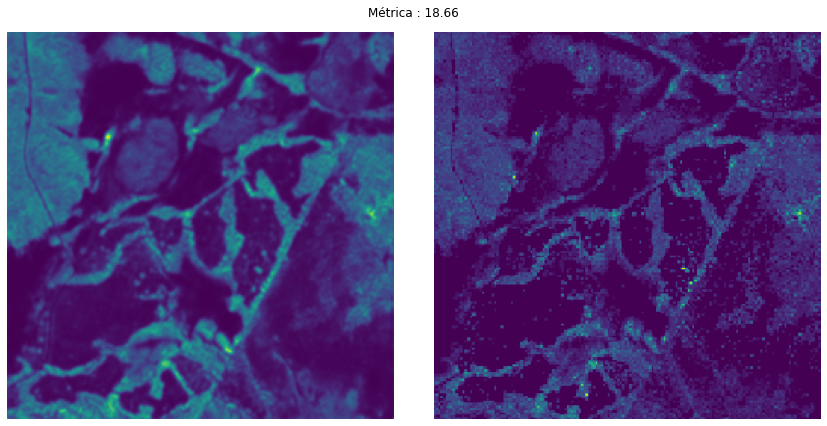

In [ ]:
max_text = 12905.3
index = np.random.randint(len(mean_preds))
fig = plt.figure(figsize=(12, 6))
metrica = module.compute_metrics(torch.unsqueeze(mean_preds[index],0),torch.unsqueeze(g[index],0)).item()
fig.suptitle(f'Métrica : {metrica:.2f}')
plt.subplot(121)
plt.imshow(mean_preds[index]*max_text)
plt.axis('off')
plt.subplot(122)
plt.imshow(g[index])
plt.axis('off')
plt.tight_layout()
plt.show()